# Visuals for poster ECCV

## Examples MSD

$\bullet$ W x H $\rightarrow$ 8 x 10 floor plans
$\bullet$ customized plotting functions
$\bullet$ randomly picked samples from the dataset (not cherry-picked)

Some imports first

In [1]:
# General
import os
import random
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Geometry and graph libraries
from shapely.geometry import Polygon
import networkx as nx

# Own functions
from plot import plot_shapes
from constants import CMAP_ROOMTYPE, ROOM_NAMES
from utils import load_pickle

Set the path from where the graphs can be loaded

In [3]:
datapath = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\modified-swiss-dwellings\graph_out'

Extract the list of IDs from the folder

In [ ]:
# Gather IDs in a list
ids = [int(i[:-7]) for i in os.listdir(datapath)]

# Check consistency: number of files in folder == length IDs? Should be the same.
print(len(os.listdir(datapath)))
print(len(np.unique(ids)))

Pick 80 IDs at random

In [ ]:
# Set seed for reproducibility
random.seed(12345)

# Randomly sample
w = 12
h = 12
ids_N = random.sample(ids, w*h)
print(ids_N)

# Graphs
graphs = [load_pickle(os.path.join(datapath, f'{id}.pickle')) for id in ids_N]

Maybe: order on amount of nodes

In [ ]:
# sizes = [G.number_of_nodes() for G in graphs]
# order = np.argsort(sizes).tolist()
# ids_N = [ids_N[i] for i in order]
# graphs = [graphs[i] for i in order]
#
# print(ids_N)

We can now create a big figure:

In [ ]:
# Set up a figure
fs = 10
fig, axs = plt.subplots(h, w, figsize=(fs*w, fs*h))
fig.set_facecolor('white')
axs = axs.flatten()

for i, id in enumerate(ids_N):

    # Get and make-up axis
    ax = axs[i]
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # Load graph
    G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
    # print(f'ID{id:6.0f}:\t{G}')

    # Extract information
    shapes = [Polygon(n) for _, n in G.nodes('geometry')]
    colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in G.nodes('room_type')]
    pos = {n: np.array(G.nodes[n]['centroid']) for n in G.nodes}

    # Draw shapes
    plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)

    # Determine node and edge size
    rel_size = 30
    node_size = fs * 13 * np.power(rel_size / G.number_of_nodes(), 2)
    edge_size = fs / 3 * np.power(rel_size / G.number_of_nodes(), 1)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='black', ax=ax)

    # Draw edges (door and passage)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d in ["door", "passage"]]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
                           width=edge_size, ax=ax)

    # Draw edges (door)
    # edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "passage"]
    # nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
    #                        width=edge_size, ax=ax)

    # Draw edges (entrance)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "entrance"]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red',
                           width=edge_size*2, ax=ax)

    # Title based on
    # ax.set_title(id, fontsize=fs*5)
    # if i == 0:
    #     legend_patches = [mpatches.Patch(color=np.array(CMAP_ROOMTYPE(j)).reshape(1,4), label=cat.capitalize())
    #                       for j, cat in enumerate(ROOM_NAMES)]
    #     _ = ax.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0., fontsize=fs*2)

os.makedirs(r'./data/dump', exist_ok=True)
plt.savefig(f'./data/dump/fig_poster_msd_examples_{w}x{h}.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Buildings at scale: solving a packing problem

In [ ]:
!pip install rectangle-packer

$\bullet$ Compute sizes

In [ ]:
from shapely.geometry import Polygon
from utils import find_floor_boundary

# Get sizes for each floor plan; add 1 meter
sizes = []
mins = []
for G in graphs:
    # Extract polygons
    polygons = [Polygon(n) for _, n in G.nodes('geometry')]

    # Initialize variables for min/max X and Y
    min_x = float('inf')
    max_x = float('-inf')
    min_y = float('inf')
    max_y = float('-inf')

    # Loop over all polygons
    for polygon in polygons:
        # Extract the x and y coordinates of the polygon's exterior
        x_coords, y_coords = polygon.exterior.xy

        # Update the min and max values
        min_x = min(min_x, min(x_coords))
        max_x = max(max_x, max(x_coords))
        min_y = min(min_y, min(y_coords))
        max_y = max(max_y, max(y_coords))

    # Compute sizes
    size_x = int(np.ceil(max_x - min_x)) + 2
    size_y = int(np.ceil(max_y - min_y)) + 2
    sizes.append((size_x, size_y))
    mins.append((int(min_x), int(min_y)))

# Sizes should come as a list of tuples with integer-valued X and Y size.
print(sizes)

Get an idea of the size of the size of the overall rectangle

In [ ]:
areas = [size[0]*size[1] for size in sizes]
tot_area = np.sum(areas)
print(tot_area)
print(np.sqrt(tot_area))  # Could use as indicator for one size of the square (or rectangle)

$\bullet$ Run packing algorithm
$\bullet$ For 70 samples $\rightarrow$ grid of 400 x 200 m $\rightarrow$ 80000 m2.

In [ ]:
print(sizes[0])

$\bullet$ _The result is returned as a list of coordinates “(x, y)”, which specifies the location of each corresponding input rectangle’s lower left corner._ (from: [rectangle-packer](https://rectangle-packer.readthedocs.io/en/latest/rpack.html))

In [ ]:
import rpack

# Enforce grid (default: X=400 x Y=200 m for 70 samples)
max_width = 520
max_height = 260

# Pack and compute positions
positions = rpack.pack(sizes, max_width=max_width, max_height=max_height)
print(positions)

Plot associated rectangles

In [ ]:
def create_rectangle(w, h, a=0, b=0):
    """
    Creates an axis-aligned rectangle with lower-left corner at (a, b),
    width w, and height h.

    Parameters:
    a (float): X-coordinate of the lower-left corner.
    b (float): Y-coordinate of the lower-left corner.
    w (float): Width of the rectangle.
    h (float): Height of the rectangle.

    Returns:
    Polygon: A Shapely Polygon representing the rectangle.
    """
    # Define the four corner points of the rectangle
    lower_left = (a, b)
    lower_right = (a + w, b)
    upper_right = (a + w, b + h)
    upper_left = (a, b + h)

    # Create and return the rectangle as a Polygon
    rectangle = Polygon([lower_left, lower_right, upper_right, upper_left, lower_left])

    return rectangle

In [ ]:
rectangles = [create_rectangle(size[0], size[1], pos[0], pos[1]) for size, pos in zip(sizes, positions)]

Plot rectangles

In [ ]:
fs=10
fig, ax = plt.subplots(1,1,figsize=(fs,fs*2))
_ = [ax.axis('off'), ax.axes.set_aspect('equal')]
fig.set_facecolor('black')
ax.set_facecolor('black')

# Set random colors for the rectangles
np.random.seed(1)
randints = np.random.randint(low=0, high=9, size=len(rectangles))
colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for n in randints]

# Plot random rectangles
plot_shapes(ax, rectangles, colors=colors, ec="black", lw=0, alpha=1)

Plot corresponding floor plans, in the same scale :)

In [ ]:
from plot import plot_polygon

# Fig setup
fs = 100
fig, ax = plt.subplots(1,1,figsize=(fs,fs*2))
fig.set_facecolor('white')
ax.set_facecolor('white')
_ = [ax.axis('off'), ax.axes.set_aspect('equal')]

# Graph setup
node_size = fs * 1.5
edge_size = fs / 60

# Plot rectangles
# _ = [ax.plot(*rect.exterior.xy, color="black") for rect in rectangles]
# plot_shapes(ax, rectangles, colors=[[]]*len(rectangles), fc=None, ec='black', lw=2, alpha=1)

for G, pos, min_xy in zip(graphs, positions, mins):

    # Determine shift
    # - position of rectangle's lower-left corner point;
    # - the minimum x and y of the floor plan
    shift = np.array(pos) - np.array(min_xy) + 2

    # Extract information + shift
    shapes = [Polygon(n + shift) for _, n in G.nodes('geometry')]
    colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in G.nodes('room_type')]
    pos = {n: np.array(G.nodes[n]['centroid']) + shift for n in G.nodes}

    # Draw shapes
    plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='black', ax=ax)

    # Draw edges (door and passage)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d in ["door", "passage"]]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
                           width=edge_size, ax=ax)

    # Draw edges (entrance)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "entrance"]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red',
                           width=edge_size*2, ax=ax)

plt.savefig(f'./data/dump/fig_poster_msd_examples_packing_without_{w}x{h}.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Graph container visual

In [ ]:
# Floor plan ID
id = 1099

# Set up a figure
fs = 10
fig, axs = plt.subplots(2, 2, figsize=(fs*2, fs*1.3))
axs = axs.flatten()
fig.set_facecolor('white')

# Graph setup
node_size = fs * 10
edge_size = fs / 6

# Load graph
G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
# print(f'ID{id:6.0f}:\t{G}')

# Extract information
shapes = [Polygon(n) for _, n in G.nodes('geometry')]
colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in G.nodes('room_type')]
pos = {n: np.array(G.nodes[n]['centroid']) for n in G.nodes}

# Draw shapes
shapes_left = [shape for shape in shapes if np.array(shape.centroid)[0] < -5]
shapes_mid = [shape for shape in shapes if -5 < np.array(shape.centroid)[0] < 5]

for i, ax in enumerate(axs):

    # Set up axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # Draw shapes
    if i == 3:
        plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)
    elif i == 1:
        plot_shapes(ax, shapes, ["gray"]*len(shapes), ec="black", lw=0, alpha=1)
    else:
        pass

    # Draw nodes
    if i == 2:
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=colors, ax=ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='black', ax=ax)

    # Draw edges (door and passage)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d in ["door", "passage"]]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
                           width=edge_size, ax=ax)

    # Draw edges (entrance)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "entrance"]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red',
                           width=edge_size*2, ax=ax)


plt.savefig(f'./data/dump/fig_poster_graph_container_2x2.png', dpi=300, bbox_inches='tight', pad_inches=0)

$\bullet$ Zoning graph $\rightarrow$ also labels

In [ ]:
print([n for n in G_zone.nodes(data=True)])

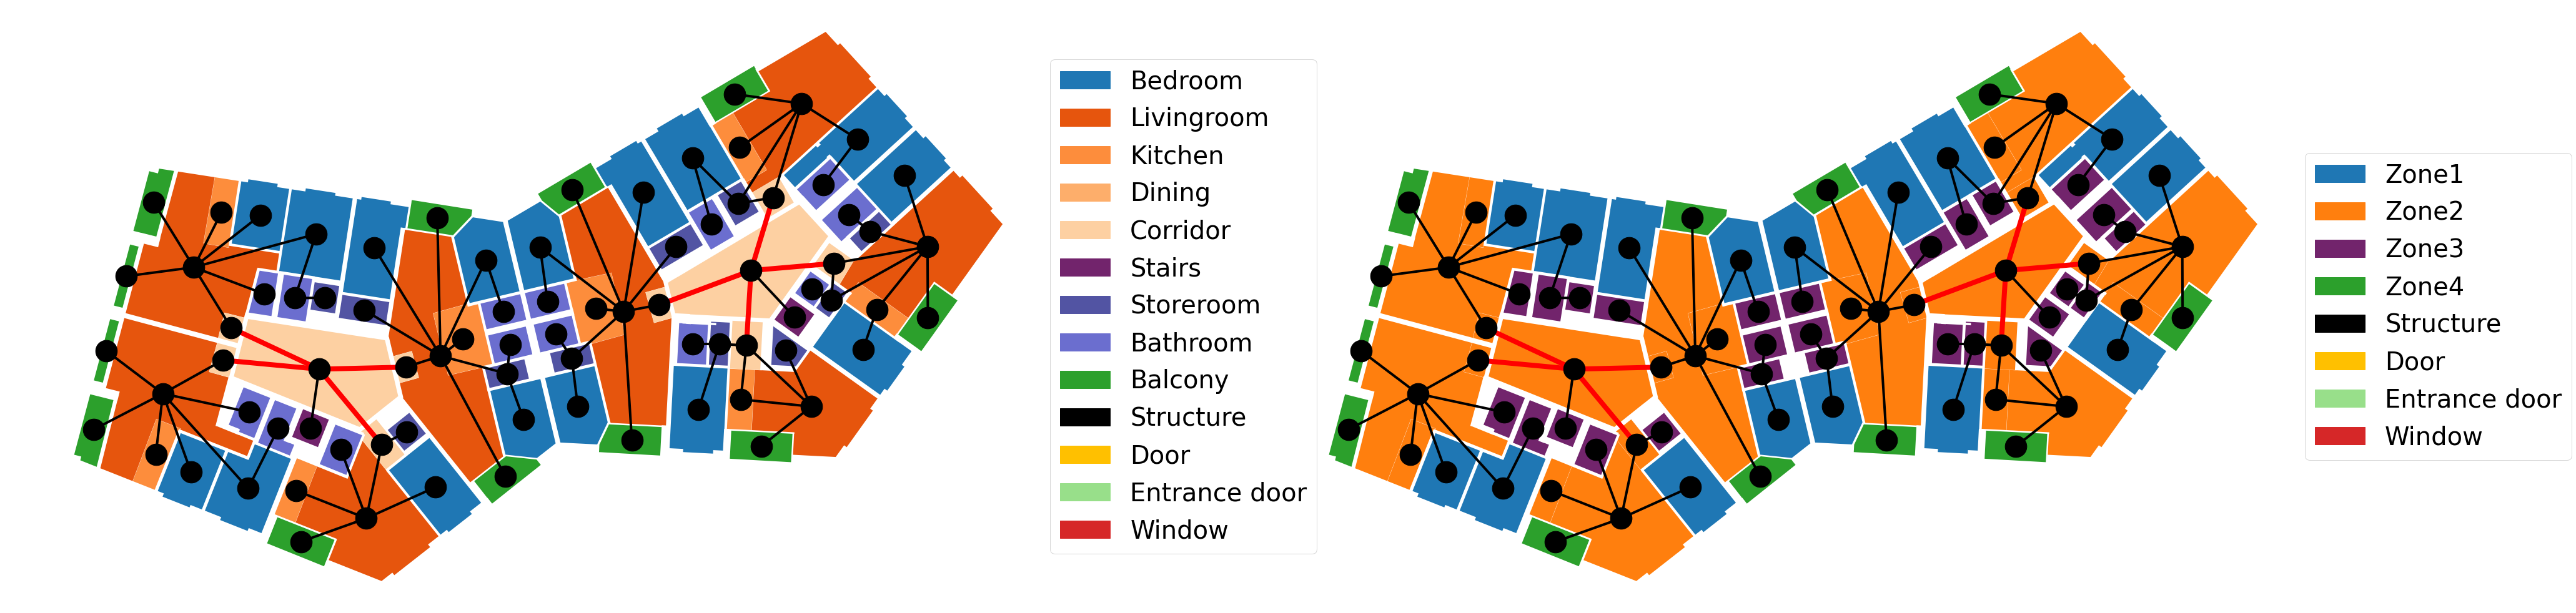

In [4]:
from constants import ZONING_NAMES, CMAP_ZONING

# Floor plan ID
id = 1099

# Set up a figure
fs = 20
fig, axs = plt.subplots(1, 2, figsize=(fs*3.3, fs*1))
axs = axs.flatten()
fig.set_facecolor('white')

# Graph setup
node_size = fs * 60
edge_size = fs / 5

# Load graph
G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
shapes = [Polygon(n) for _, n in G.nodes('geometry')]
datapath_zone = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\modified-swiss-dwellings\graph_in'
G_zone = load_pickle(os.path.join(datapath_zone, f'{id}.pickle'))
# print(f'ID{id:6.0f}:\t{G}')

# Extract information
pos = {n: np.array(G.nodes[n]['centroid']) for n in G.nodes}

for i, ax in enumerate(axs):

    # Set up axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # Draw nodes
    if i == 0:
        colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in G.nodes('room_type')]
        cmap = CMAP_ROOMTYPE
        names = ROOM_NAMES
    elif i == 1:
        cmap = CMAP_ZONING
        names = ZONING_NAMES
        colors = [np.array(CMAP_ZONING(n)).reshape(1,4) for _, n in G_zone.nodes('zoning_type')]
    else:
        raise NotImplementedError

    plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="black", ax=ax)

    # Draw edges (door and passage)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d in ["door", "passage"]]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
                           width=edge_size, ax=ax)

    # Draw edges (entrance)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "entrance"]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red',
                           width=edge_size*2, ax=ax)

    legend_patches = [mpatches.Patch(color=np.array(cmap(j)).reshape(1,4), label=cat.capitalize())
                      for j, cat in enumerate(names)]
    _ = ax.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0., fontsize=fs*2)

# plt.savefig(f'./data/dump/fig_poster_semantics_horizontal.png', dpi=300, bbox_inches='tight', pad_inches=0)

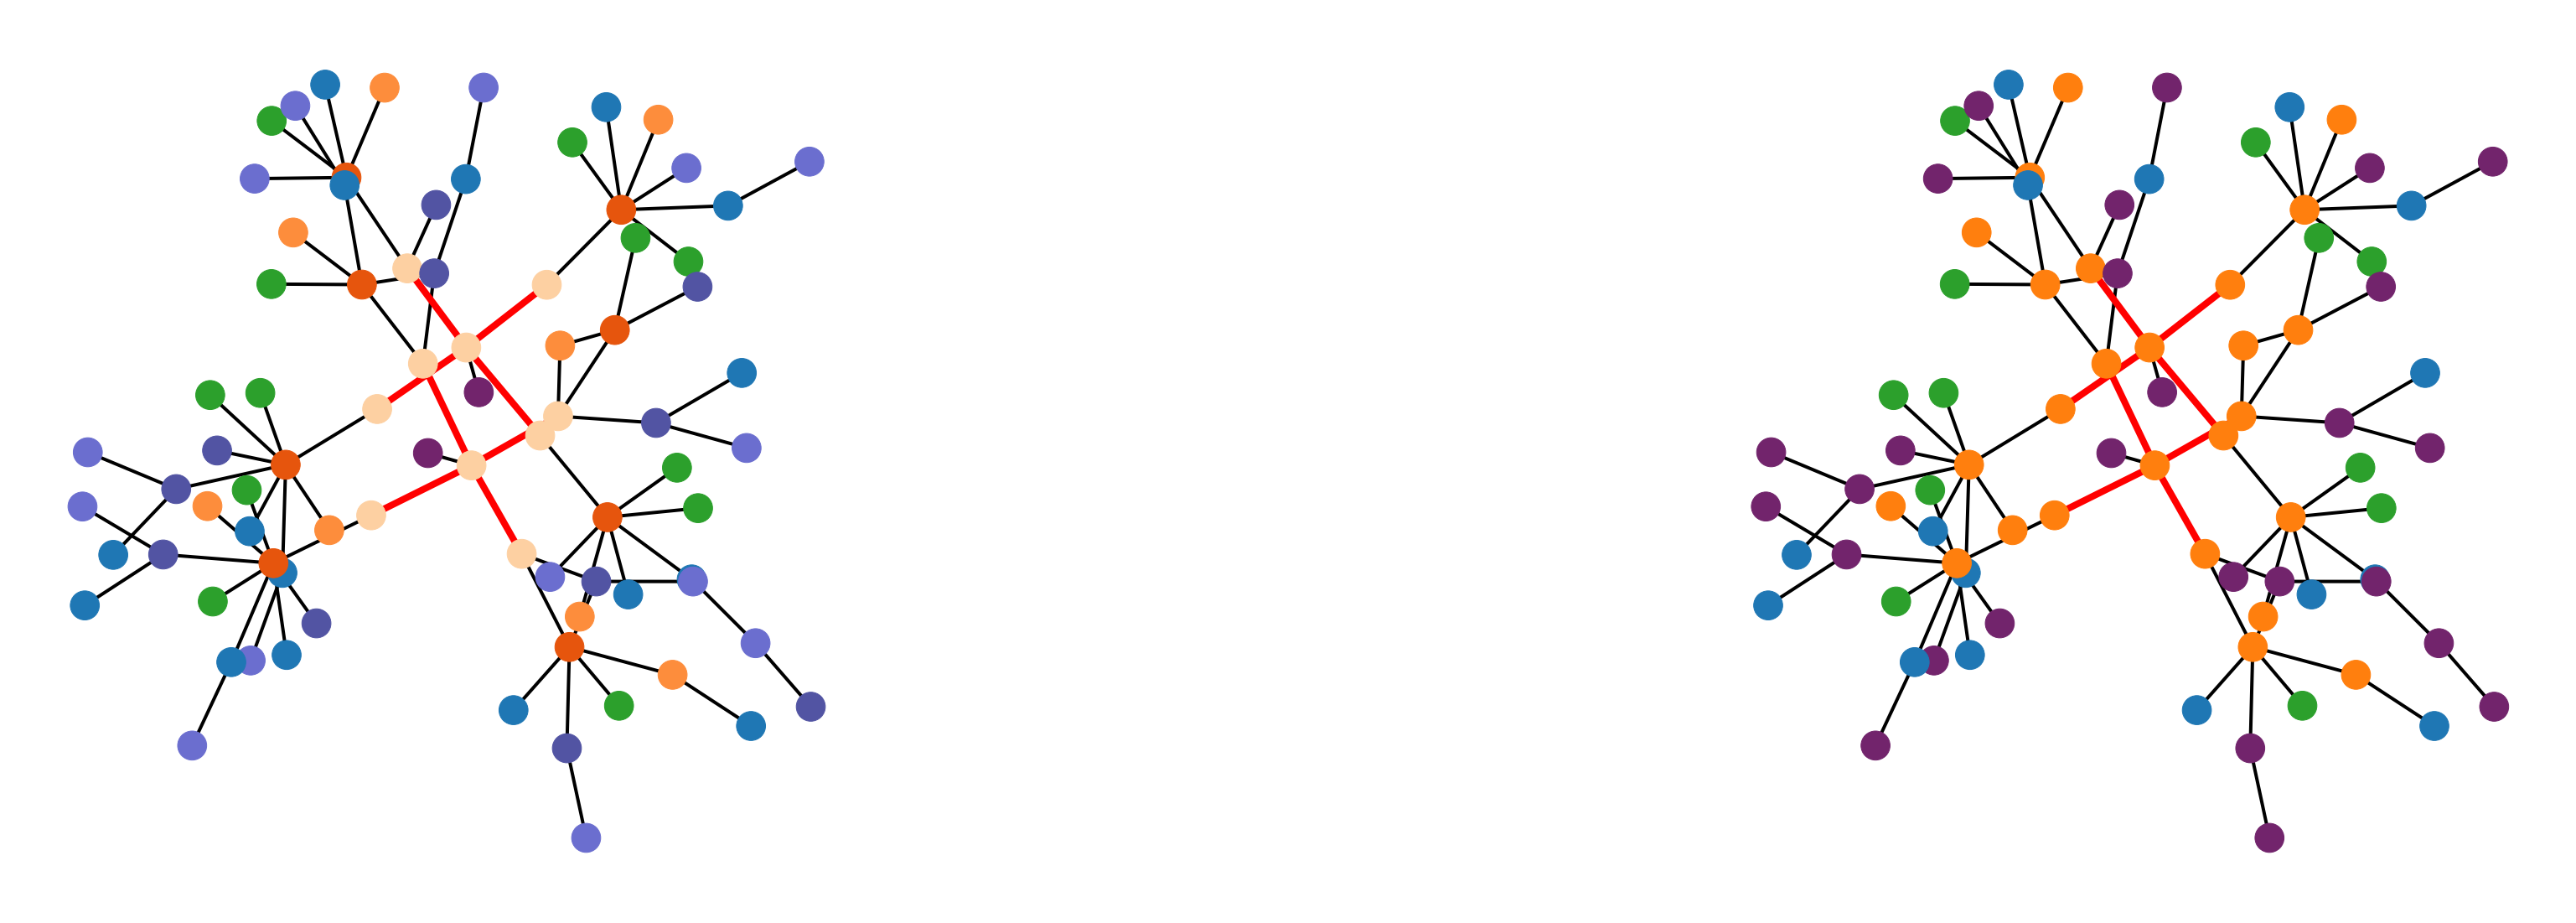

In [5]:
from constants import ZONING_NAMES, CMAP_ZONING

# Floor plan ID
id = 1099

# Set up a figure
fs = 20
fig, axs = plt.subplots(1, 2, figsize=(fs*3.3, fs*1))
axs = axs.flatten()
fig.set_facecolor('white')

# Graph setup
node_size = fs * 60
edge_size = fs / 5

# Load graph
G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
shapes = [Polygon(n) for _, n in G.nodes('geometry')]
datapath_zone = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\modified-swiss-dwellings\graph_in'
G_zone = load_pickle(os.path.join(datapath_zone, f'{id}.pickle'))
# print(f'ID{id:6.0f}:\t{G}')

# Extract information
# pos = {n: np.array(G.nodes[n]['centroid']) for n in G.nodes}
pos = nx.kamada_kawai_layout(G)

for i, ax in enumerate(axs):

    # Set up axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # Draw nodes
    if i == 0:
        colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in G.nodes('room_type')]
        cmap = CMAP_ROOMTYPE
        names = ROOM_NAMES
    elif i == 1:
        cmap = CMAP_ZONING
        names = ZONING_NAMES
        colors = [np.array(CMAP_ZONING(n)).reshape(1,4) for _, n in G_zone.nodes('zoning_type')]
    else:
        raise NotImplementedError

    # plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=colors, ax=ax)

    # Draw edges (door and passage)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d in ["door", "passage"]]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
                           width=edge_size, ax=ax)

    # Draw edges (entrance)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "entrance"]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red',
                           width=edge_size*2, ax=ax)

    # legend_patches = [mpatches.Patch(color=np.array(cmap(j)).reshape(1,4), label=cat.capitalize())
    #                   for j, cat in enumerate(names)]
    # _ = ax.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0., fontsize=fs*2)

# plt.savefig(f'./data/dump/fig_poster_semantics_horizontal_only_graph.png', dpi=300, bbox_inches='tight', pad_inches=0)

Zoning for particular set of plans

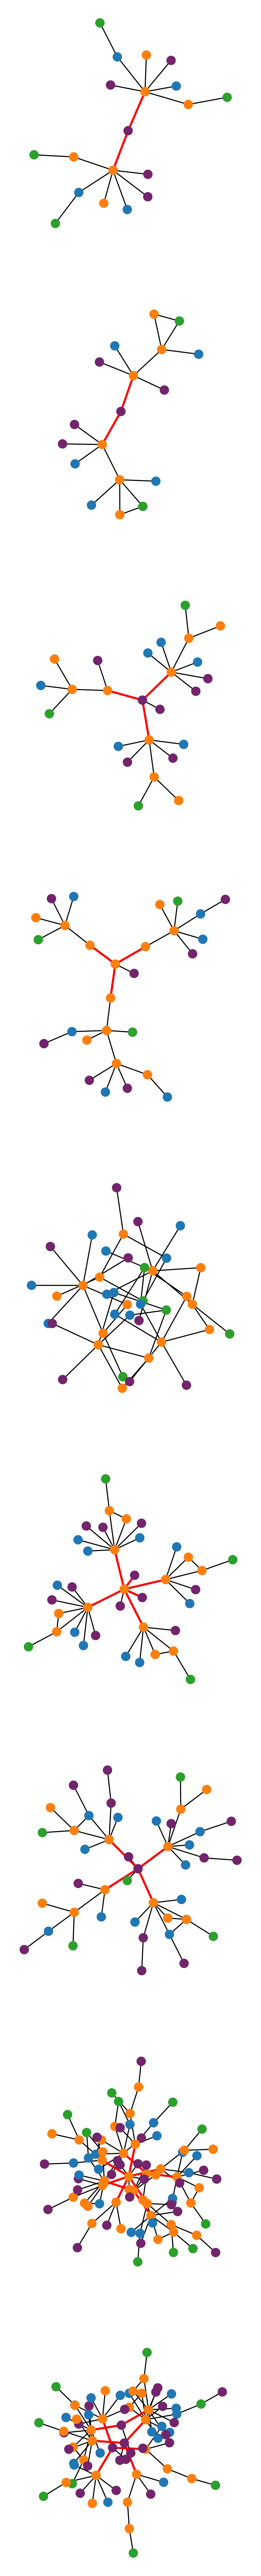

In [8]:
floor_ids = [2295,
             # 2027,
             # 2413,
             2999,
             2011,
             1118,
             # 3907,
             # 15389,
             2824,
             7435,
             # 47705,
             # 15074,
             46637,
             10484,
             # 15103,
             46509]

from constants import ZONING_NAMES, CMAP_ZONING

# Set up a figure
fs = 20
fig, axs = plt.subplots(len(floor_ids), 1, figsize=(fs, fs*len(floor_ids)))
axs = axs.flatten()
fig.set_facecolor('white')

# Graph setup
node_size = fs * 60
edge_size = fs / 5

# Extract information
# pos = {n: np.array(G.nodes[n]['centroid']) for n in G.nodes}

for i, ax in enumerate(axs):

    # Load graph
    id = floor_ids[i]
    G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
    pos = nx.kamada_kawai_layout(G)
    # shapes = [Polygon(n) for _, n in G.nodes('geometry')]
    datapath_zone = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\modified-swiss-dwellings\graph_in'
    G_zone = load_pickle(os.path.join(datapath_zone, f'{id}.pickle'))
    # print(f'ID{id:6.0f}:\t{G}')

    # Set up axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # Draw nodes
    cmap = CMAP_ZONING
    names = ZONING_NAMES
    colors = [np.array(CMAP_ZONING(n)).reshape(1,4) for _, n in G_zone.nodes('zoning_type')]

    # plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=colors, ax=ax)

    # Draw edges (door and passage)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d in ["door", "passage"]]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black',
                           width=edge_size, ax=ax)

    # Draw edges (entrance)
    edges = [(u, v) for (u, v, d) in G.edges(data="connectivity") if d == "entrance"]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red',
                           width=edge_size*2, ax=ax)

    # legend_patches = [mpatches.Patch(color=np.array(cmap(j)).reshape(1,4), label=cat.capitalize())
    #                   for j, cat in enumerate(names)]
    # _ = ax.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0., fontsize=fs*2)

plt.savefig(f'./data/dump/fig_poster_zone_graphs_examples.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Necessary structure

In [ ]:
# set up figure
fs = 20
fig, ax = plt.subplots(1, 1, figsize=(fs, fs))

datapath_structure = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\modified-swiss-dwellings\struct_in'


# set axis
_ = [ax.axis('off'), ax.axes.set_aspect('equal')]

# get structural components
stack = np.load(os.path.join(datapath_structure, f'{id}.npy'))

# channel 1: structural components
# note: channel 2 and 3 are x and y locations
#   this holds for "full_out" as well
struct = stack[..., 0].astype(np.uint8)
ax.imshow(struct, cmap='gray')

xys = stack[..., 1:]
bounds = np.array([xys[0, 0], xys[-1, -1]])

plt.savefig(f'./data/dump/fig_poster_necessary_structure.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Diffusion of floor plans

In [ ]:
def add_noise_to_polygon(polygon, noise_level=0.2, noise_level_t=1, noise_level_s=0.5):
    """
    Add noise to a polygon by perturbing its vertices.

    :param polygon: A Shapely Polygon object.
    :param noise_level: The maximum distance to perturb each vertex.
    :return: A new Shapely Polygon with noise added.
    """
    # Get the coordinates of the polygon
    x, y = polygon.exterior.xy

    # Generate noise for each vertex
    noise_x = np.random.uniform(-noise_level, noise_level, size=len(x))
    noise_y = np.random.uniform(-noise_level, noise_level, size=len(y))

    # Generate noise for translation
    noise_x_t = np.random.uniform(-noise_level_t, noise_level_t, size=1)
    noise_y_t = np.random.uniform(-noise_level_t, noise_level_t, size=1)

    # Generate noise for scale
    noise_x_s = np.random.uniform(1-noise_level_s, 1+noise_level_s, size=len(x))
    noise_y_s = np.random.uniform(1-noise_level_s, 1+noise_level_s, size=len(x))

    # Create new vertices with noise
    new_x = (x + noise_x + noise_x_t) * noise_x_s
    new_y = (y + noise_y + noise_y_t) * noise_y_s

    # Create a new polygon with the noisy vertices
    noisy_polygon = Polygon(zip(new_x, new_y))

    return noisy_polygon

Noise the polygons

In [ ]:
T = 1000

# Load graph
id = 1099
G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
shapes = [Polygon(n) for _, n in G.nodes('geometry')]

# Initialize & settings
noise_level = 0.2
noise_level_t = 0.5
noise_level_s = 0.01
np.random.seed(1)
shapes_evolution = [shapes]

# Add noise to shapes
shapes_noised = shapes
for t in range(1, T):
    shapes_noised = [add_noise_to_polygon(p, noise_level=noise_level,
                                          noise_level_t=noise_level_t,
                                          noise_level_s=noise_level_s)
                     for p in shapes_noised]
    shapes_evolution.append(shapes_noised)

print(len(shapes_evolution))

Diffusion proces

In [ ]:
from constants import ZONING_NAMES, CMAP_ZONING

# Floor plan ID
id = 1099

# Set up a figure
fs = 10
fig, axs = plt.subplots(4, 1, figsize=(fs*1, fs*2.5))
axs = axs.flatten()
fig.set_facecolor('white')

# Graph setup
node_size = fs * 60
edge_size = fs / 5

# Load graph
G = load_pickle(os.path.join(datapath, f'{id}.pickle'))
# print(f'ID{id:6.0f}:\t{G}')

# Extract information
colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in G.nodes('room_type')]

for ax, shapes in zip(axs, (shapes_evolution[:3] + shapes_evolution[-1:])[::-1]):

    # Set up axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    plot_shapes(ax, shapes, colors, ec="black", lw=0, alpha=1)

plt.savefig(f'./data/dump/fig_poster_diffusion.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Pixel values

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Load image: 1st channel, integer-valued
path_img = r'C:\Users\caspervanengel\OneDrive - Delft University of Technology\DDS_RES Casper Overview\Figures\Modified Swiss Dwellings\zumthor secular retreat.png'
img = (255 * plt.imread(path_img)[..., 0]).astype(np.uint8)

print(img.shape)

img = img[460:490,470:500]
print(img)
print(img.shape)

(1100, 1054)
[[109 154 254 210  78 243 255 255 255 255 255 255 255 255 255 255 254 149
  195 255 255 255 255 255 252 229 117 223 132   2]
 [138 174 254 219 113 246 255 254 235 210 236 255 254 255 255 255 255 202
  146 253 255 254 241 197 142 124 158 243 199  20]
 [247 249 255 252 245 253 253 187  77  68 141 215 132 159 234 238 237 235
  125 216 200 150 122 151 203 238 252 255 240  70]
 [255 255 255 255 227 152 189 195 188 231 240 235 156 126 215 136  77 148
  151  66 100 187 236 254 255 255 255 255 253 140]
 [255 252 233 238 123  96 206 254 255 255 255 255 255 253 254 233 199 208
  213  99  83 203 159 119 169 235 232 242 253 201]
 [244 144  84 203 233 244 254 255 255 255 255 255 255 255 255 255 255 255
  254 248 238 227 121  69  94 147  92  84 204 191]
 [218 141 194 249 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 252 193 122 161 231 208 135 220 198 232 174]
 [240 253 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  243 162 134 219 253 255 243 125 228 

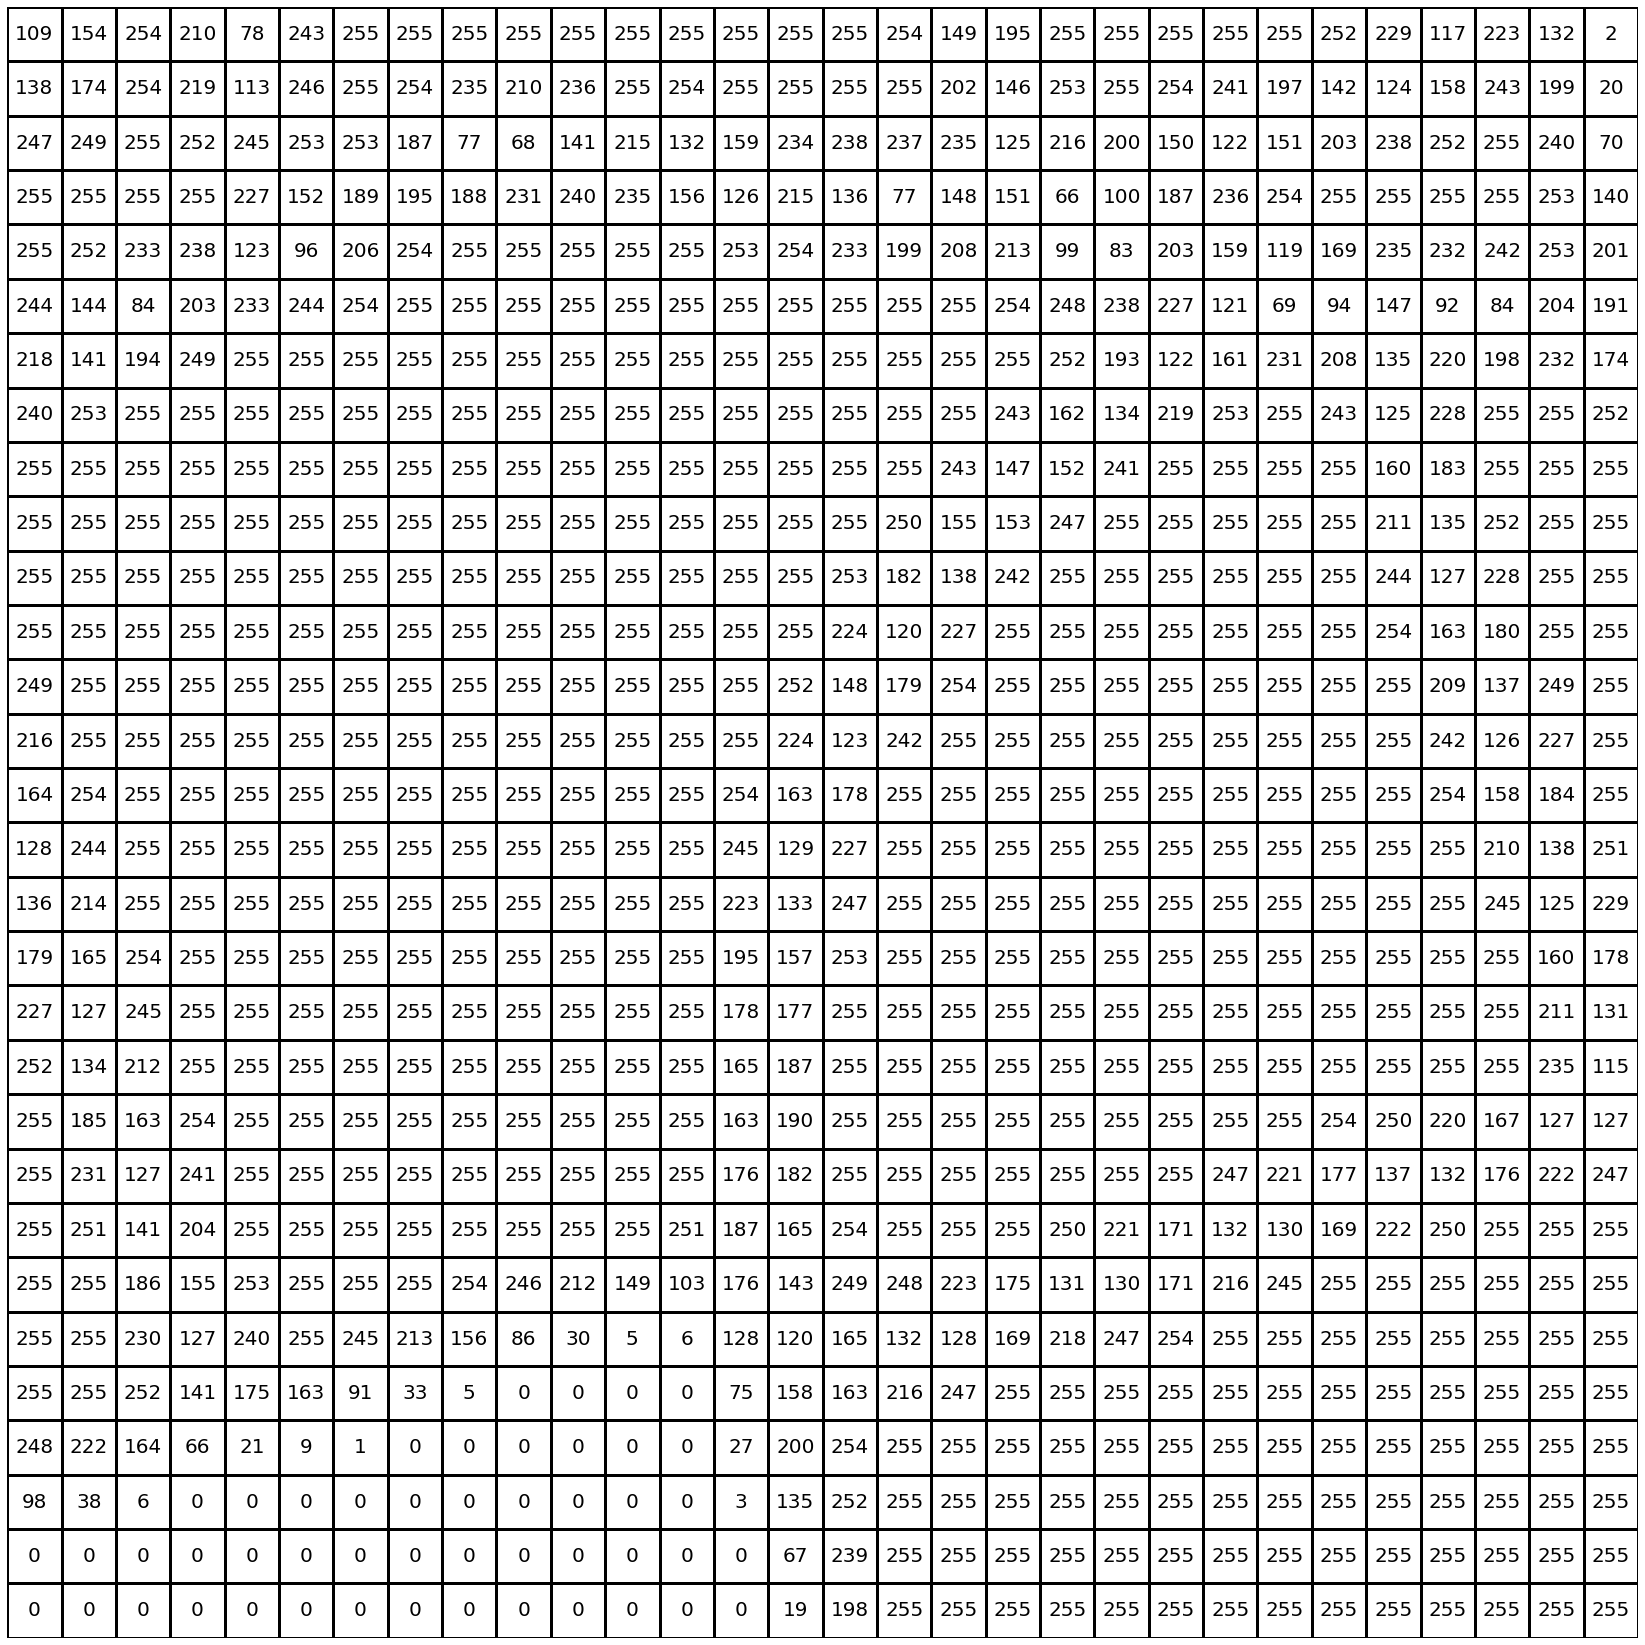

<Figure size 432x288 with 0 Axes>

In [46]:
fs = 30
fig, ax = plt.subplots(1,1, figsize=(fs, fs))
fig.set_facecolor('white')
ax.set_facecolor('white')

# Hide axes
_ = [ax.axis('off'), ax.set_aspect('equal')]

# Set limits
ax.set_xlim(-0.5, img.shape[1]-0.5)
ax.set_ylim(-0.5, img.shape[0]-0.5)

# Invert y-axis to have the first row at the top
ax.invert_yaxis()

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Draw vertical gridlines
for x in range(img.shape[1]+1):
    ax.axvline(x-0.5, color='black', linewidth=fs/10)

# Draw horizontal gridlines
for y in range(img.shape[0]+1):
    ax.axhline(y-0.5, color='black', linewidth=fs/10)

# # Add text annotations
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        ax.text(j, i, str(img[i, j]),
                ha='center', va='center', fontsize=fs/1.5, color='black')

plt.show()

plt.savefig(f'./data/dump/fig_text_pixels.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [32]:
import cv2

path_img = r'C:\Users\caspervanengel\OneDrive - Delft University of Technology\DDS_RES Casper Overview\Figures\Modified Swiss Dwellings\zumthor secular retreat.png'
img = (255 * plt.imread(path_img)[..., 0]).astype(np.uint8)
img = img[420:540,430:550]

img = cv2.resize(img, (20, 20), interpolation=cv2.INTER_LINEAR)

print(img)

[[255 198 160 246 255 255 255 255 255 197 255 124   0   0 251 255 255 255
  255 255]
 [239 255 255 255 255 255 255 255 255 233 255   0   0   0  50 255 255 252
  165 254]
 [193 174 255 255 255 255 255 255 255 255 255   2   0   0   0 255 255 255
  250 192]
 [255 242 255 255 255 255 255 255 255 255 190 204   0   0   0 247 255 255
  255 255]
 [255 255 255 255 255 255 255 255 255 255 241  94   0   0   0  38 255 255
  255 255]
 [255 255 233 190 255 177 255 255 255 177 227   0   0   0   0   0 255 255
  255 255]
 [188 144 136 174 240 240 238 161 255 177 255  21   0   0   0   0 242 255
  255 255]
 [172 255 255 255 255 255 255 174 255 229 117 212   0   0   0   0  27 255
  255 255]
 [255 255 255 255 255 175 174 255 255 167 255 255   0   0   0   0   0 252
  255 255]
 [255 254 252 214 255 255 253 255 255 255 255 173   0   0   0   0   0 235
  255 255]
 [247 158 255 255 255 255 255 255 218 245 181 255   0   0   0   0   3 204
  255 255]
 [255 255 255 255 255 230  13   0   0 255 255 255  21  74 254 255

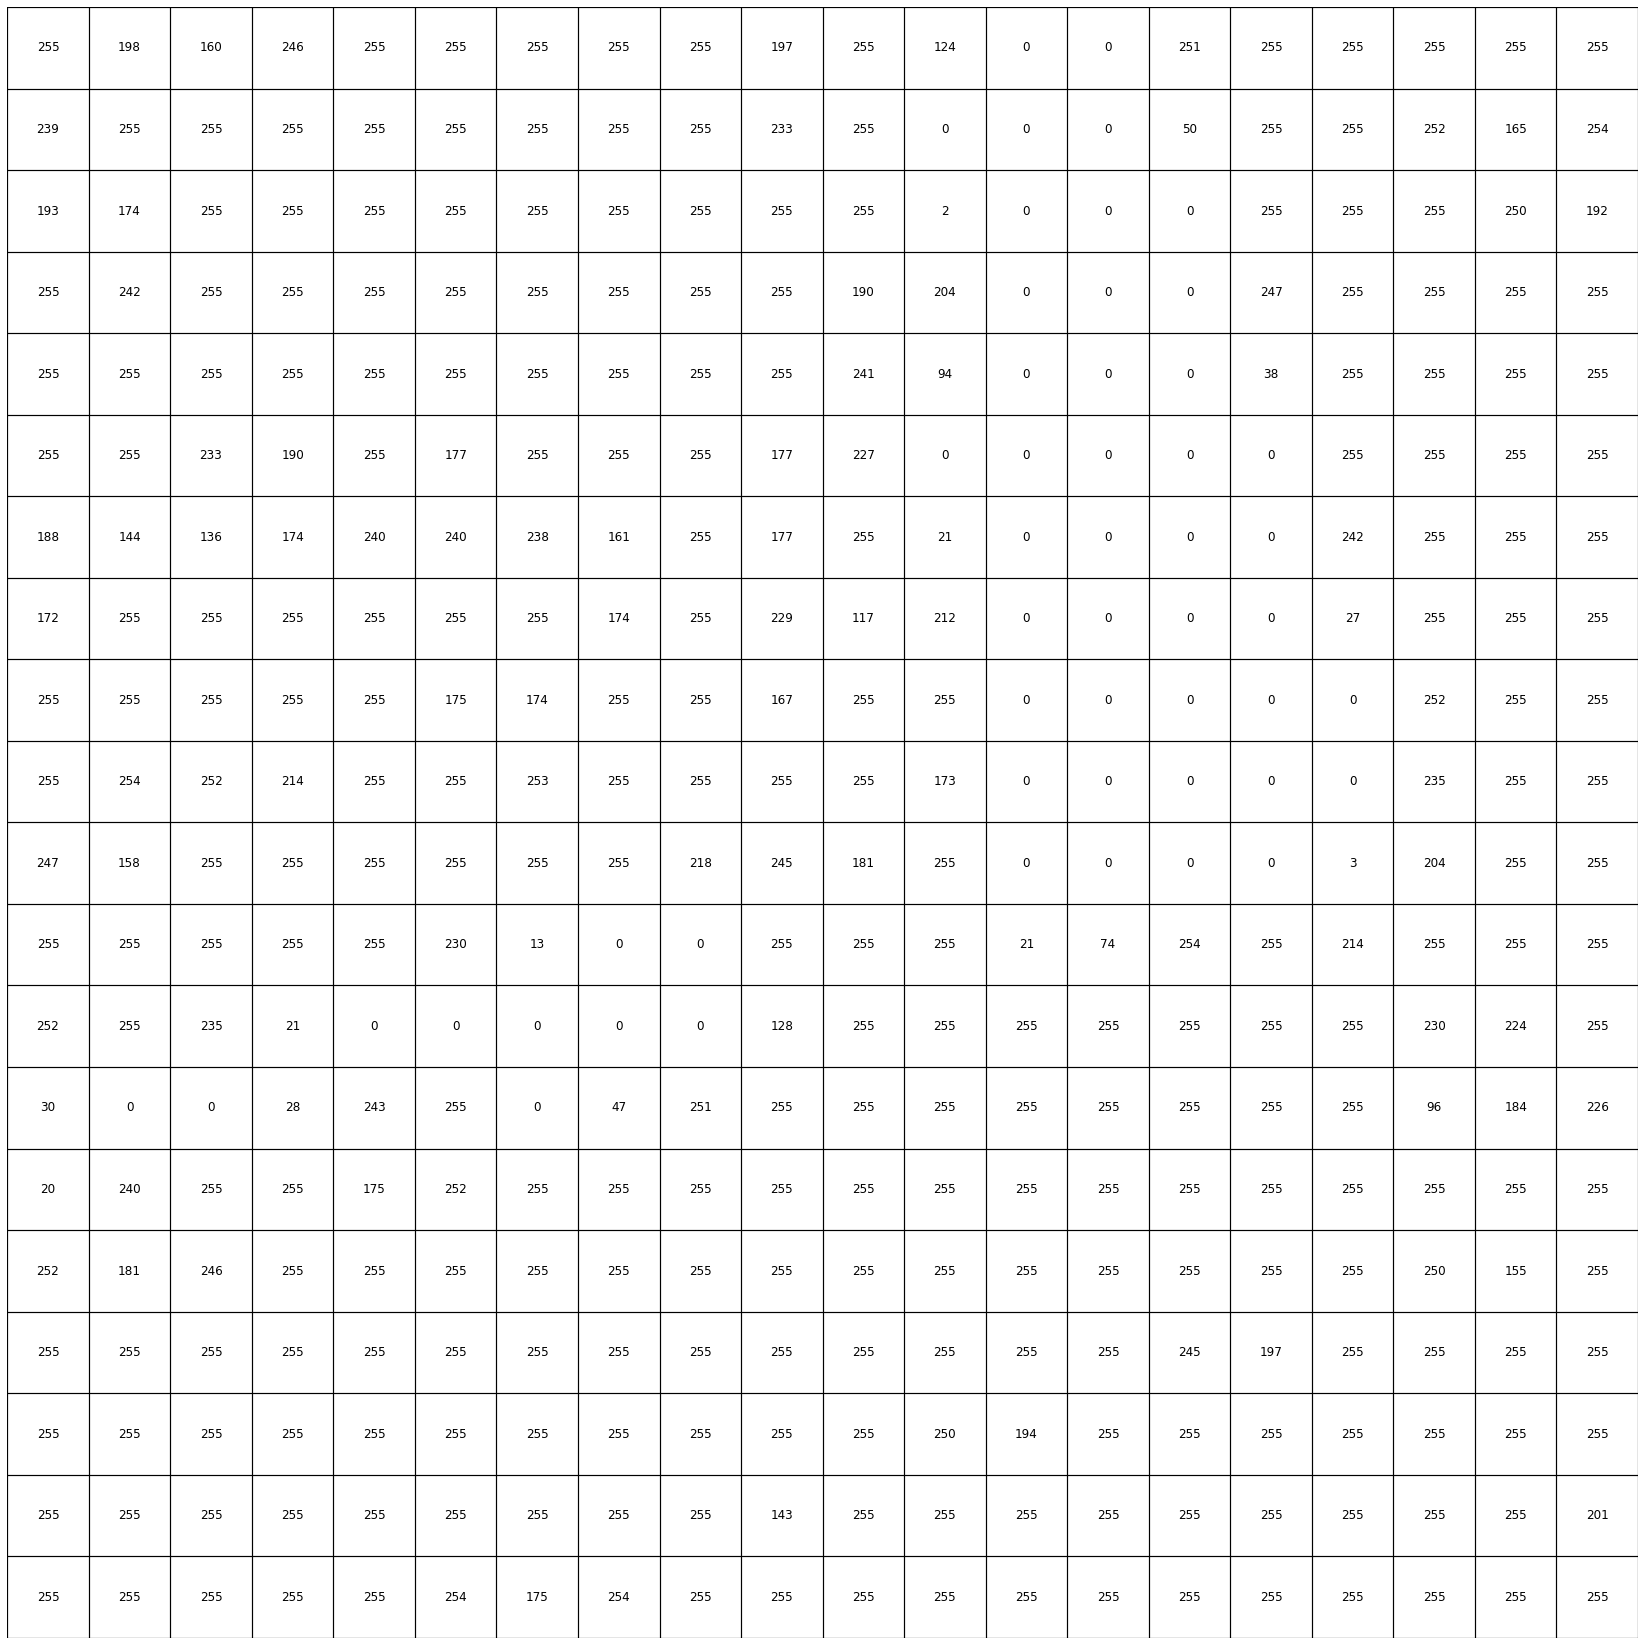

<Figure size 432x288 with 0 Axes>

In [33]:
fs = 30
fig, ax = plt.subplots(1,1, figsize=(fs, fs))
fig.set_facecolor('white')
ax.set_facecolor('white')

# Hide axes
_ = [ax.axis('off'), ax.set_aspect('equal')]

# Set limits
ax.set_xlim(-0.5, img.shape[1]-0.5)
ax.set_ylim(-0.5, img.shape[0]-0.5)

# Invert y-axis to have the first row at the top
ax.invert_yaxis()

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Draw vertical gridlines
for x in range(img.shape[1]+1):
    ax.axvline(x-0.5, color='black', linewidth=fs/25)

# Draw horizontal gridlines
for y in range(img.shape[0]+1):
    ax.axhline(y-0.5, color='black', linewidth=fs/25)

# # Add text annotations
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        ax.text(j, i, str(img[i, j]),
                ha='center', va='center', fontsize=fs/2.5, color='black')

plt.show()

plt.savefig(f'./data/dump/fig_text_pixels_down.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [76]:
# Load image: 1st channel, integer-valued
path_img = r'C:\Users\caspervanengel\OneDrive - Delft University of Technology\DDS_RES Casper Overview\Figures\Modified Swiss Dwellings\zumthor secular retreat.png'
img = (255 * plt.imread(path_img)[..., 0]).astype(np.uint8)

# Make binary
# _, img = cv2.threshold(img, 128, 1, cv2.THRESH_BINARY)

# Crop
img = img[450:550, 450:550]

# Downscale image
img = cv2.resize(img, (40, 40), interpolation=cv2.INTER_LINEAR_EXACT)

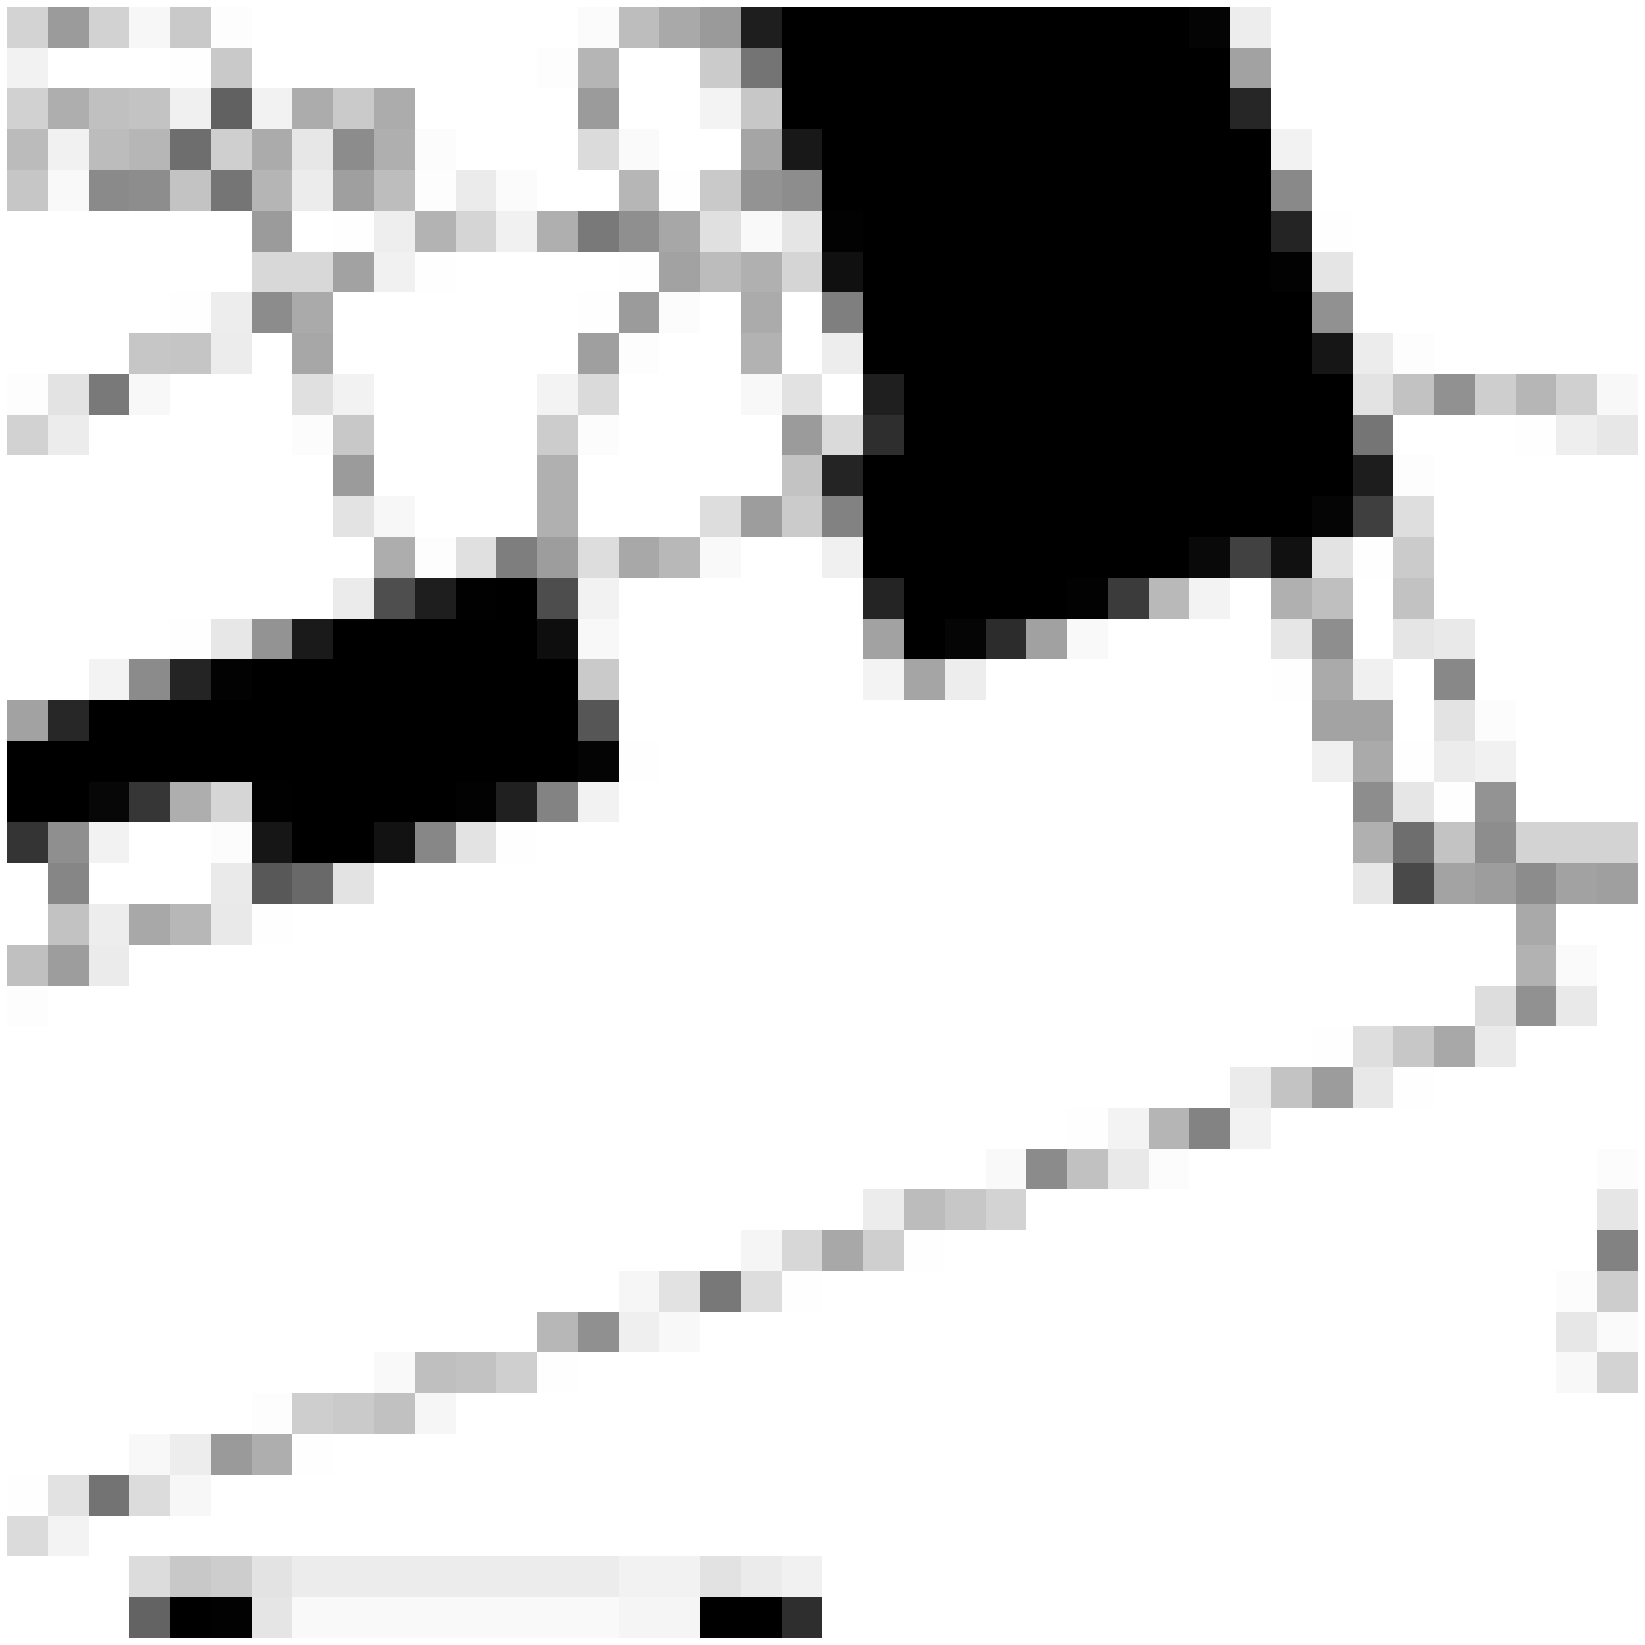

In [77]:
fs = 30
fig, ax = plt.subplots(1,1, figsize=(fs, fs))
fig.set_facecolor('white')
ax.set_facecolor('white')

ax.axis('off')

ax.matshow(img, cmap="gray")

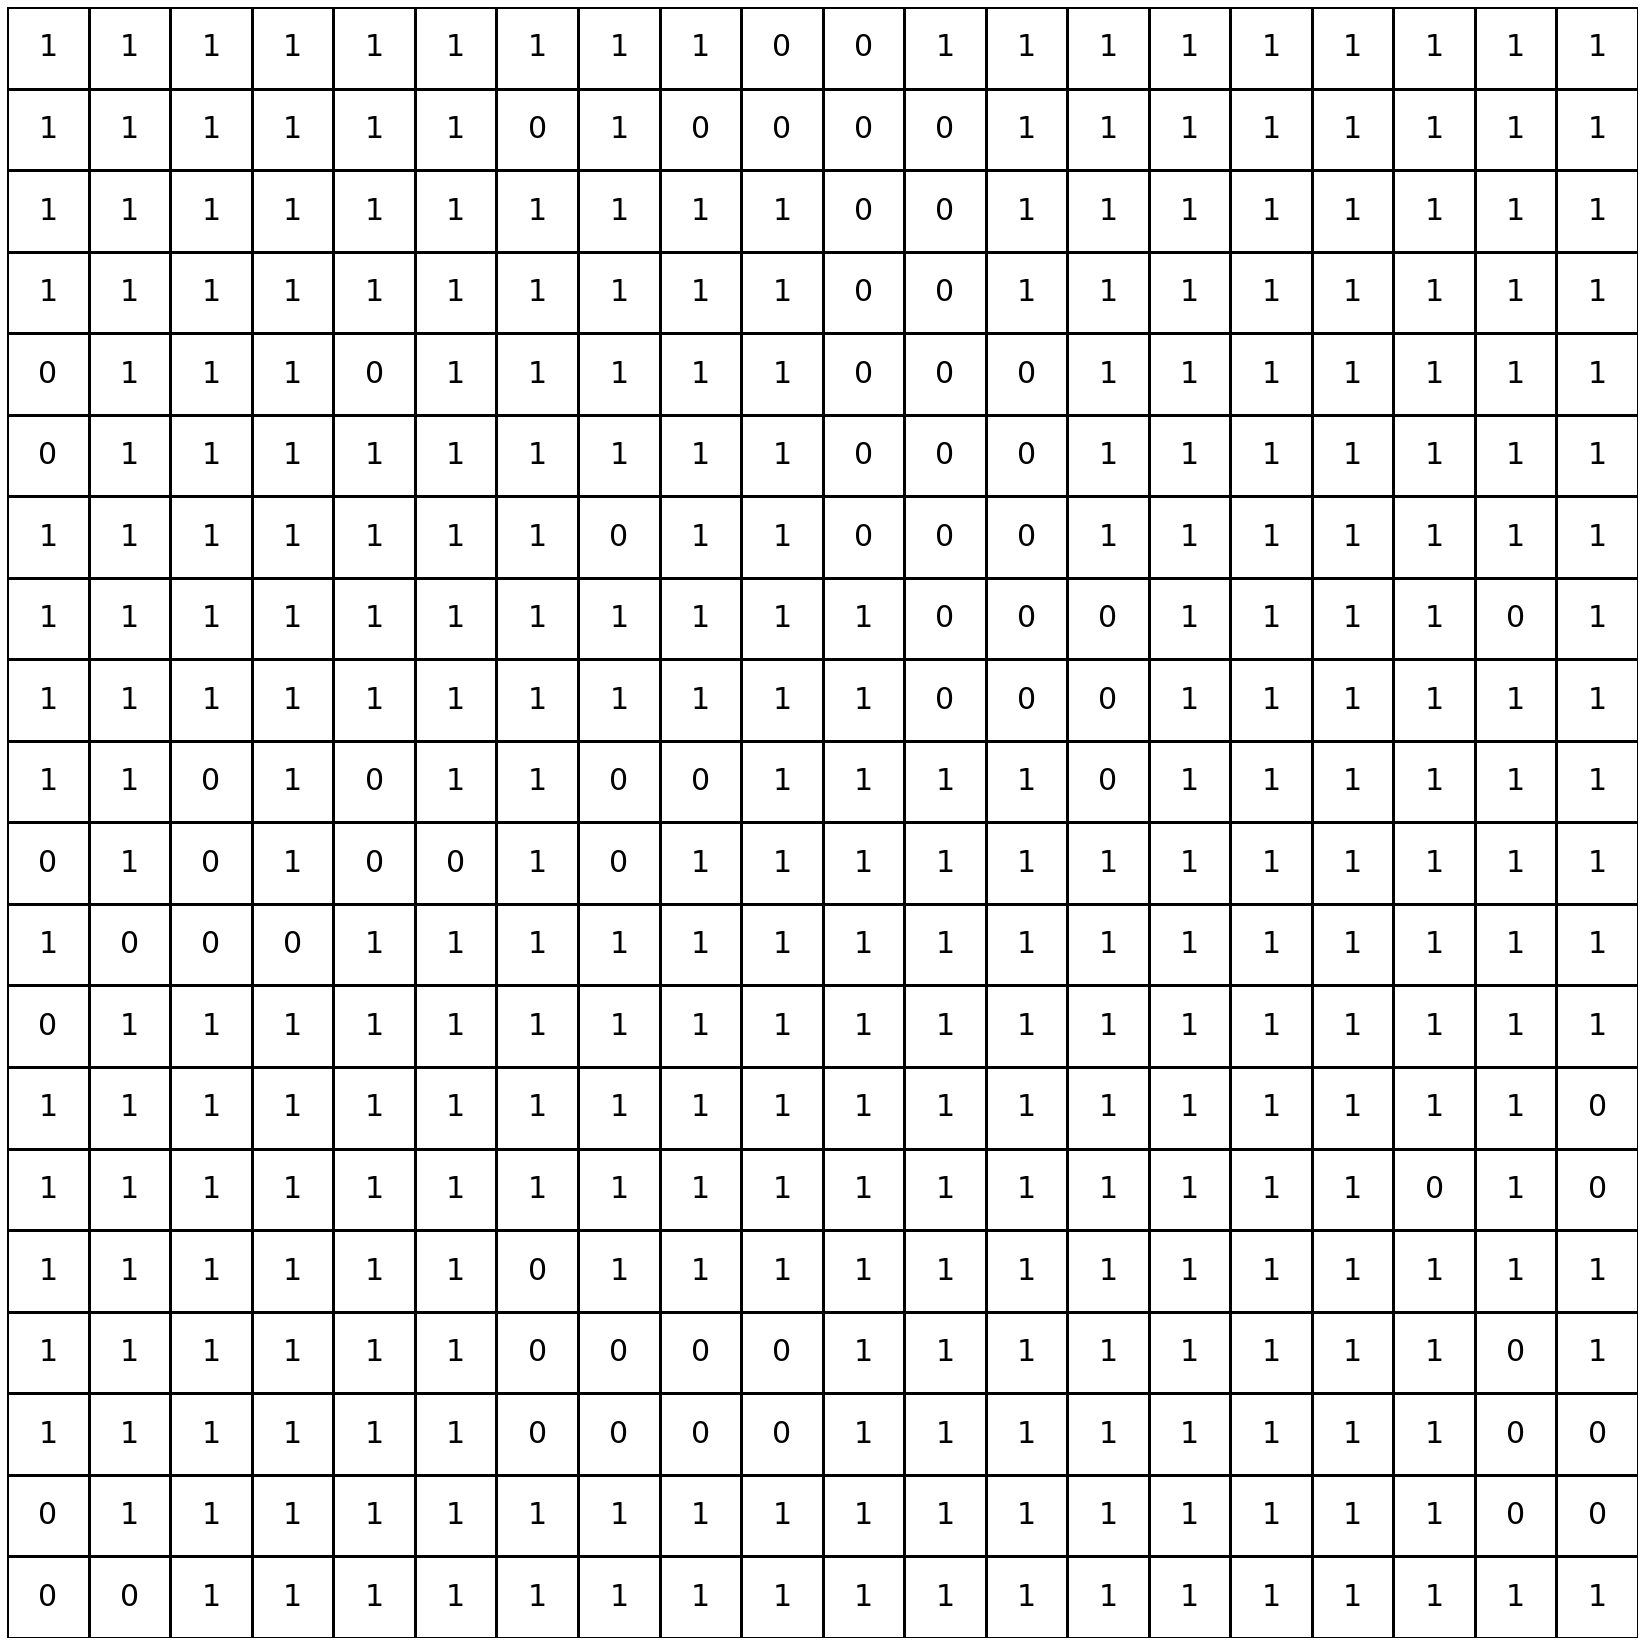

In [56]:
fs = 30
fig, ax = plt.subplots(1,1, figsize=(fs, fs))
fig.set_facecolor('white')
ax.set_facecolor('white')

# Hide axes
_ = [ax.axis('off'), ax.set_aspect('equal')]

# Set limits
ax.set_xlim(-0.5, img.shape[1]-0.5)
ax.set_ylim(-0.5, img.shape[0]-0.5)

# Invert y-axis to have the first row at the top
ax.invert_yaxis()

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Draw vertical gridlines
for x in range(img.shape[1]+1):
    ax.axvline(x-0.5, color='black', linewidth=fs/10)

# Draw horizontal gridlines
for y in range(img.shape[0]+1):
    ax.axhline(y-0.5, color='black', linewidth=fs/10)

# # Add text annotations
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        ax.text(j, i, str(img[i, j]),
                ha='center', va='center', fontsize=fs, color='black')

plt.show()

## Examples RPLAN